In [63]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from matplotlib import pyplot
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import shapiro
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import classification_report, roc_curve, auc, log_loss, f1_score, precision_score, accuracy_score, recall_score  
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import ElasticNet

from IPython.display import Markdown, display 
def printmd(string):  
    display(Markdown(string)) 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

### Datasets

In [23]:
dataset = pd.read_csv('datasets/SCALED.csv')

images_to_drop = ["image_249.jpg", "image_465.jpg", "image_503.jpg", "image_86.jpg", "image_87.jpg",
                 "image_496.jpg", "image_70.jpg", "image_36.jpg", "image_301.jpg", "image_185.jpg",
                 "image_144.jpg", "image_12.jpg", "image_18.jpg", "image_453.jpg", "image_481.jpg",
                 "image_529.jpg", "image_559.jpg", "image_87.jpg", "image_4.jpg", "image_470.jpg",
                 "image_396.jpg"]

mask = dataset['image_name'].isin(images_to_drop)
dataset = dataset[~mask]

dataset = dataset.set_index('image_name')

In [24]:
ratings = dataset[['seba_binary' ,'seba_quintary', 'piotr_binary',
       'piotr_quintary', 'maciej_binary', 'maciej_quintary', 'karol_binary',
       'karol_quintary', 'michal_binary', 'michal_quintary']]

ratings_to_remove = ['seba_binary', 'seba_quintary' , 'piotr_binary',
       'piotr_quintary', 'maciej_binary', 'maciej_quintary', 'karol_binary',
       'karol_quintary', 'michal_binary', 'michal_quintary', 'rational_one', 'rational_two']
dataset = dataset.drop(ratings_to_remove, axis = 1)

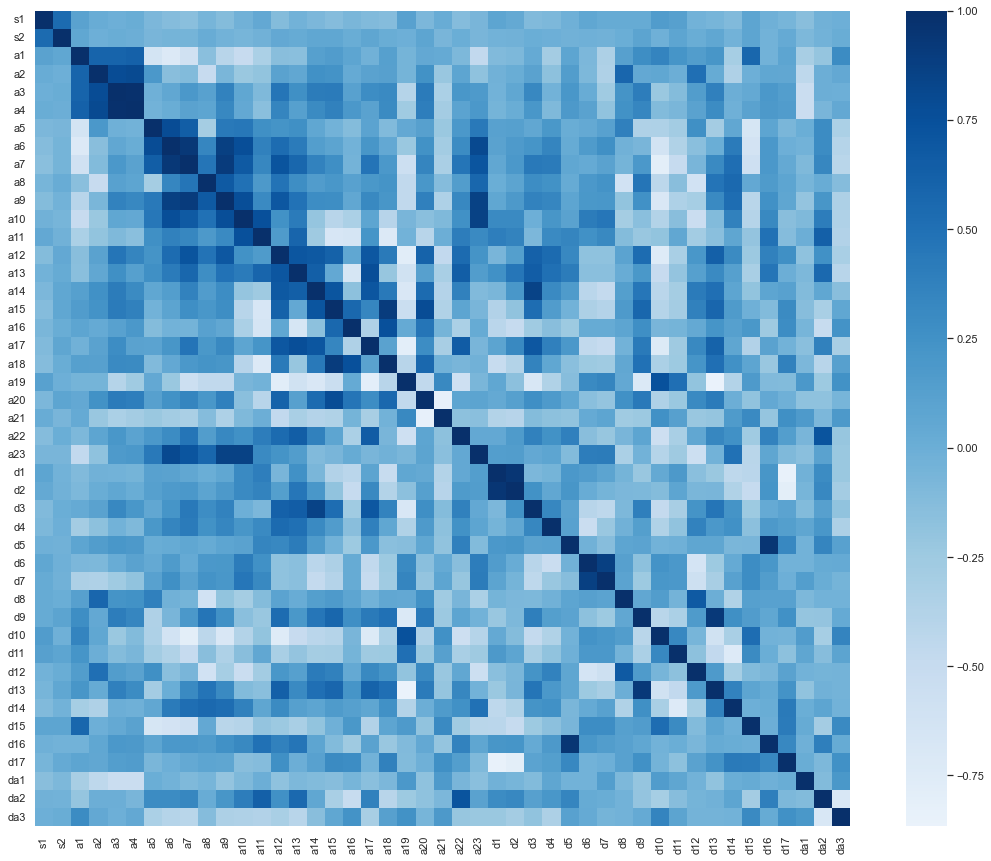

In [25]:
plt.figure(figsize=(20, 15))
sns.set(style="white")
corr = dataset.corr('pearson')
cmap = sns.diverging_palette(600, 550, as_cmap=True)
sns.heatmap(corr, cmap='Blues', center=0,
            square=True, annot = False);

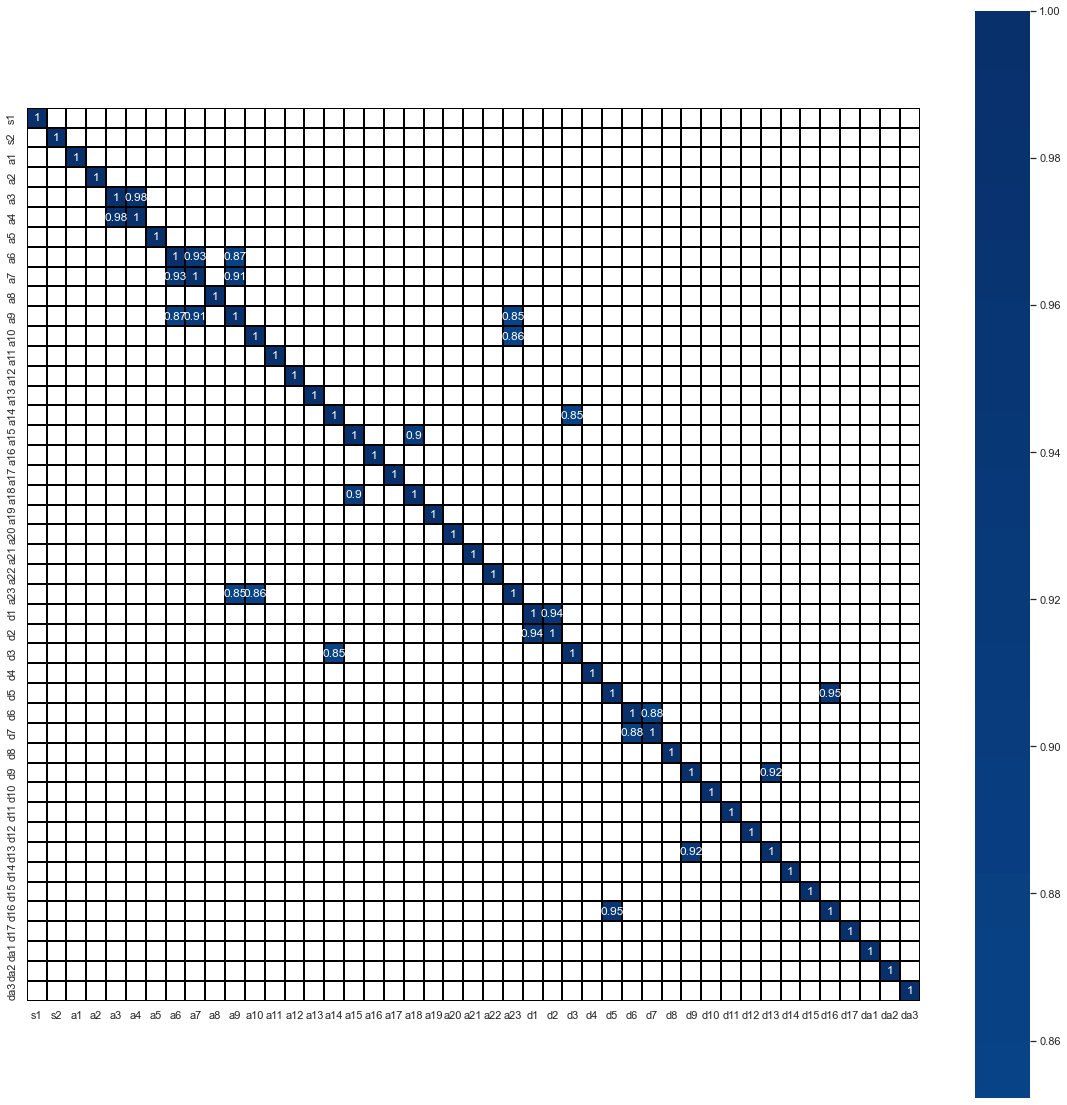

In [26]:
sns.set(style="white")
corr = dataset.corr('pearson')
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

mask = corr < 0.85

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(600, 550, as_cmap=True)
sns.heatmap(corr, mask = mask, cmap='Blues', center=0,
            square=True, annot = True, linewidths=.2, linecolor = 'black');

In [27]:
variables_to_remove = ['a9','a23', 'd3', 'd13', 'd16']
dataset = dataset.drop(variables_to_remove, axis = 1)

### Dictionary


**s1 = eye_area_symmetry** right_eye_area / left_eye_area
    

**s2 = eye_length_symmetry** right_eye_length/left_eye_length


    
#### area ratios

**a1 = eyes_to_lips** right_eye_area + left_eye_area / lip_area
    

**a2 = eyes_to_nose** right_eye_area + left_eye_area / nose_area
    

**a3 = eyes_to_face** (right_eye_area + left_eye_area) / face_area
    

**a4 = eyes_to_top_face** (right_eye_area + left_eye_area) / top_face_area
    

**a5 = lips_to_nose** lip_area / nose_area
    

**a6 = lips_to_face** lip_area / face_area
    

**a7 = lips_to_lower_face** lip_area / lower_face_area
    

**a8 = nose_to_face** nose_area / face_area
    

**a9 = eyes_lips_nose_to_face** (right_eye_area + left_eye_area + lip_area + nose_area) / face_area)
    

**a10 = eyes_lips_nose_to_inner_face** (right_eye_area + left_eye_area + lip_area + nose_area) / inner_triangle_area
    

**a11 = features_to_triangle** features_area / inner_triangle_area
    

**a12 = features_to_face** features_area / face_area
    

**a13 = features_to_outer** features_area / (left_outer_face_area + right_outer_face_area)
    

**a14= inner_to_outer** inner_triangle_area / (left_outer_face_area + right_outer_face_area)
    

**a15 = inner_to_face** inner_triangle_area / face_area
    

**a16 = outer_to_face** left_outer_face_area + right_outer_face_area) / face_area
    

**a17 = top_face_to_face** top_face_area / face_area
    

**a18 = upper_face_to_face** upper_face_area / face_area
    

**a19 = lower_face_to_face** lower_face_area / face_area
    

**a20 = bottom_face_to_face** bottom_face_area / face_area
    

**a21 = upper_to_bottom** upper_face_area / bottom_face_area
    

**a22 = vision_to_face** right_vision_area + left_vision_area / face_area


**a23 = nose_lips_eyes_to_features_area** (nose_area + right_eye_area + left_eye_area + lip_area) / features_area
    
#### distances
    

**d1 = face_length_to_width_top** face_length / face_width_at_top
    

**d2 = face_length_to_width_bottom** face_length / face_width_at_bottom
    

**d3 = face_top_to_bottom_width** face_width_at_top/face_width_at_bottom
    

**d4 = eye_distance_to_face_width** eye_distance /  face_width_at_top
    

**d5 = eyebrows_to_face_width** (right_eyebrow_length + left_eyebrow_length) / face_width_at_top
    

**d6 = mouth_to_eye_distance** mouth_length / eye_distance
    

**d7 = mouth_to_eye_spread** mouth_length / eye_outer_distance
    

**d8 = mouth_to_nose_width** mouth_length / nose_width
    

**d9 = nose_length_to_face_length** nose_length/face_length
    

**d10 = bottom_distance_to_face** chin_to_mouth_distance / face_length
    

**d11 = nose_to_mouth_to_face** mouth_to_nose_distance / face_length
       

**d12 = eye_distance_to_nose_width** eye_distance / nose_width
    

**d13 = nose_length_to_nose_to_chin_distance** nose_length / nose_to_chin_distance
    

**d14 = nose_width_to_nose_mouth_distance** nose_width / mouth_to_nose_distance


**d15 = mouth_length_to_width** mouth_length / mouth_width


**d16 = features_length_to_face_width** (right_eyebrow_length + left_eyebrow_length + mouth_length + left_eyebrow_length + right_eyebrow_length) / face_width_at_top)


**d17 = features_length_to_face_length** (right_eyebrow_length + left_eyebrow_length + mouth_length + left_eyebrow_length + right_eyebrow_length) / face_length
    
    
    
#### distances and areas
    

**da1 = eyebrows_to_eyes** (right_eyebrow_length + left_eyebrow_length) / (right_eye_area + left_eye_area))
    

**da2 = vision_to_face_width** (right_vision_area + left_vision_area) / face_width_at_top)


**da3 = features_length_to_features_area** (right_eyebrow_length + left_eyebrow_length + mouth_length + left_eyebrow_length + right_eyebrow_length) / features_area

### evaluating all datasets - random forest classifier

In [28]:
score_column_names = ['accuracy', 'precision', 'recall', 'f1']
#scores = pd.DataFrame(index = ratings.columns, columns = score_column_names)
scores = pd.DataFrame(columns = score_column_names)

confusion_matrices = {}
feature_importances = {}
best_parameters = {}

for column_name in ratings.columns:
    X = dataset
    y = ratings[column_name]
    
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27, stratify = y, shuffle = True)
    
    params = {"n_estimators":[ 200, 300],
              "max_features":['sqrt'],
              "max_depth":[4,5,6,7],
              "min_samples_split":[2,3],
              "min_samples_leaf":[3,4],
              "bootstrap" : [False, True]}
    random_forest = RandomForestClassifier()
    kfold = StratifiedKFold(n_splits=5,  random_state=False, shuffle = True)

    grid_search_random_forest = GridSearchCV(random_forest, params, n_jobs=5, cv=kfold,  scoring='accuracy', verbose=2, refit=True)
    grid_search_random_forest.fit(X_train, y_train)
    
    preds = grid_search_random_forest.predict(X_test)
    
    precision = precision_score(y_test, preds, average='micro')
    recall = recall_score(y_test, preds, average='micro')
    f1 = f1_score(y_test, preds, average='micro') 
   
    temporary_scores = {
      "precision": precision,
      "f1": f1,
      "recall": recall 
        }
    
    scores = scores.append(temporary_scores, ignore_index = True)
    
    confusion_matrices[column_name] = confusion_matrix(y_test, preds)
    feature_importances[column_name] = grid_search_random_forest.best_estimator_.feature_importances_
    best_parameters[column_name] = grid_search_random_forest.best_params_
    
    

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Fitting 5 folds for each of 64 candidates, totalling 320 fits


In [30]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           1       0.81      1.00      0.89        42
           2       0.67      0.57      0.62        42
           3       0.56      0.55      0.55        42
           4       0.67      0.65      0.66        43
           5       0.80      0.76      0.78        42

    accuracy                           0.71       211
   macro avg       0.70      0.71      0.70       211
weighted avg       0.70      0.71      0.70       211



In [32]:
precision_score(y_test, preds, average = 'weighted')

0.700240375353079

In [33]:
feature_importances

plt.figure(figsize = (15,5))
plt.bar(np.arange(X.shape[1]), grid_search_random_forest.best_estimator_.feature_importances_)
plt.xticks(np.arange(X.shape[1]), X.columns, rotation = 60)
plt.title('Feature Importances');
plt.show()

{'seba_binary': array([0.02059866, 0.01000984, 0.00881623, 0.04072607, 0.00972958,
        0.00736339, 0.02169979, 0.01212691, 0.01765914, 0.03785119,
        0.01673263, 0.00835601, 0.0245068 , 0.01458684, 0.05686355,
        0.0170785 , 0.00823847, 0.05989325, 0.00934095, 0.04124017,
        0.02063359, 0.02437526, 0.01952941, 0.00920414, 0.00973658,
        0.01163882, 0.00833174, 0.02598748, 0.06681143, 0.06271555,
        0.01584554, 0.01768506, 0.01655386, 0.15756461, 0.017405  ,
        0.01619306, 0.01516978, 0.01144494, 0.01406535, 0.01569086]),
 'seba_quintary': array([0.0110557 , 0.01016785, 0.01478503, 0.02034703, 0.01365639,
        0.01216643, 0.02056299, 0.014277  , 0.01848359, 0.02771716,
        0.01718049, 0.01330164, 0.03500169, 0.01626943, 0.04450863,
        0.02329793, 0.01278034, 0.05182953, 0.01856417, 0.03366559,
        0.02641143, 0.02837919, 0.01635895, 0.01517451, 0.01464777,
        0.04175759, 0.01605432, 0.02300308, 0.03385964, 0.06553771,
        0.0129

Class=3, n=230 (21.801%)
Class=4, n=88 (8.341%)
Class=5, n=244 (23.128%)
Class=1, n=38 (3.602%)
Class=2, n=81 (7.678%)


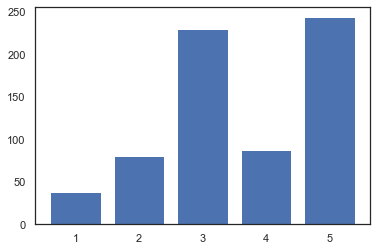

In [50]:
counter = Counter(ratings.seba_quintary)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

Class=0, n=230 (21.801%)
Class=1, n=451 (42.749%)


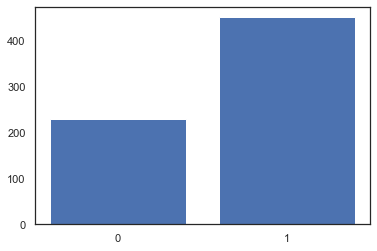

In [58]:
counter = Counter(ratings.seba_binary)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values(), tick_label = ('0', '1'))
pyplot.show()

### evaluating all datasets - xgboost

In [65]:
score_column_names = ['accuracy', 'precision', 'recall', 'f1']
#scores = pd.DataFrame(index = ratings.columns, columns = score_column_names)
scores_xgboost = pd.DataFrame(columns = score_column_names)

confusion_matrices_xgboost = {}
feature_importances_xgboost = {}
best_parameters_xgboost = {}

for column_name in ratings.columns[:2]:
    X = dataset
    y = ratings[column_name]
    
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 27, stratify = y, shuffle = True)
    
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    
    params = {"learning_rate":[0.05, 0.06],
              "max_depth":[3,4],
              "min_child_weight":[1,2],
              "colsample_bytree":[0.5,0.6],
              "n_estimators":[40,50,60],
              "scale_pos_weight" : [5,6],
              "subsample" : [0.4,0.5,0.6],
               "reg_alpha" : [5,10]}
    
    model_xgb = XGBClassifier(random_state = 1)
    kfold = StratifiedKFold(n_splits=5,  random_state=False, shuffle = True)

    grid_search_xgboost = GridSearchCV(model_xgb, params, n_jobs=5, cv=kfold,  
                                       scoring='accuracy', verbose=2, refit=True)
    grid_search_xgboost.fit(X_train, y_train)
    
    preds = grid_search_xgboost.predict(X_test)
    
    precision = precision_score(y_test, preds, average='micro')
    recall = recall_score(y_test, preds, average='micro')
    f1 = f1_score(y_test, preds, average='micro') 
   
    temporary_scores = {
      "precision": precision,
      "f1": f1,
      "recall": recall 
        }
    
    scores = scores.append(temporary_scores, ignore_index = True)
    
    confusion_matrices_xgboost[column_name] = confusion_matrix(y_test, preds)
    feature_importances_xgboost[column_name] = grid_search_xgboost.best_estimator_.feature_importances_
    best_parameters_xgboost[column_name] = grid_search_xgboost.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[02:04:23] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


